In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [97]:
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

#Dataset name
reading_dataset = 'soil-sensor-readings-historical-data'
number_of_records = 100

# Add a filter for the number of results returned
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

soil_reading_url = f'{base_url}{dataset}/{filters}'
soil_reading_url

'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/soil-sensor-locations/records?limit=100&offset=0&timezone=UTC'

In [3]:
# Use requests to get the data
result = requests.get(soil_reading_url)

In [4]:
result_json = result.json()
result_json.keys()

dict_keys(['total_count', 'links', 'records'])

In [5]:
result_json['total_count']

944070

In [6]:
records = result_json['records']

In [7]:
soil_df = pd.json_normalize(records)
soil_df.drop(columns = ['links'], inplace=True)

In [8]:
column_names = soil_df.columns.values.tolist()
column_names = [i.split('.')[-1] for i in column_names]
soil_df.columns = column_names
soil_df = soil_df.drop(columns = 'id')

In [9]:
soil_df

,timestamp,size,local_time,site_name,site_id,probe_id,probe_measure,soil_value,unit,json_featuretype
0,2023-09-01T07:08:46.91Z,128,2023-03-26T07:00:00+00:00,Treasury West,75509,1619058,Soil Moisture 80cm #0,48.91,%VWC,SoilSensorData
1,2023-09-01T07:08:46.91Z,134,2023-03-26T07:00:00+00:00,Treasury West,75509,1619067,Soil Temperature 80cm #0,17.96,ºC,SoilSensorData
2,2023-09-01T07:08:46.91Z,134,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,1303869,Soil Moisture 40cm #0,33.79,%VWC,SoilSensorData
3,2023-09-01T07:08:46.91Z,140,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,1303877,Soil Salinity 30cm #0,0.21,µS/cm,SoilSensorData
4,2023-09-01T07:08:46.91Z,140,2023-03-26T07:00:00+00:00,Princes Park Lawn 5,64993,1303875,Soil Salinity 10cm #0,0.07,µS/cm,SoilSensorData
...,...,...,...,...,...,...,...,...,...,...
95,2023-09-01T07:08:46.91Z,128,2023-03-26T11:00:00+00:00,Treasury West,75509,1619054,Soil Moisture 40cm #0,19.72,%VWC,SoilSensorData
96,2023-09-01T07:08:46.91Z,140,2023-03-26T11:00:00+00:00,Princes Park Lawn 5,64993,1303890,Soil Temperature 70cm #0,18.17,ºC,SoilSensorData
97,2023-09-01T07:08:46.91Z,128,2023-03-26T11:00:00+00:00,Treasury West,75509,1619071,#0 Soil Moisture 40cm,19.72,%VWC,SoilSensorData
98,2023-09-01T07:08:46.91Z,128,2023-03-26T11:00:00+00:00,Treasury West,75509,1619070,#0 Soil Moisture 30cm,17.41,%VWC,SoilSensorData


In [10]:
# Use links & iterate calls

def get_data(base, data_url, offset = 0):
    
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)
    
    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()
    
    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names
    
    next_url = None
    
    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']
                
    return [records_df, next_url, column_names]

In [11]:
def add_to_dataframe(dataframe, new_data):
    df = pd.concat([dataframe, new_data])
    return df

In [12]:
def extract_dataframe(base_url, dataset):
    df_new, url_next, column_names = get_data(base_url, dataset)
    df = pd.DataFrame(columns=column_names)
    while url_next != None:
        df_new, url_next, column_names = get_data(base_url, dataset, df.shape[0])
        df = add_to_dataframe(df, df_new)
        if df.shape[0] == 9900:
            break
    return df

In [95]:
soil_df = extract_dataframe(base_url, dataset)

In [96]:

soil_df

,id,timestamp,size,site_id,site_name,property_name,latitude,longitude,lon,lat


In [15]:
soil_df['probe_measure'].unique()

array(['Soil Moisture 80cm #0', 'Soil Temperature 80cm #0',
       'Soil Moisture 40cm #0', 'Soil Salinity 30cm #0',
       'Soil Salinity 10cm #0', 'Soil Moisture 20cm #0 (Clayey Loam)',
       'Soil Moisture 30cm #0', 'Soil Temperature 10cm #0',
       'Soil Moisture 10cm #0', 'Soil Moisture 70cm #0 (Clay)',
       'Soil Moisture 80cm #0 (Clay)', 'Soil Temperature 70cm #0',
       'Soil Salinity 20cm #0', 'Soil Moisture 20cm #0',
       '#0 Soil Moisture 80cm', 'Soil Temperature 20cm #0',
       'Soil Moisture 60cm #0', '#0 Soil Moisture 70cm',
       'Soil Moisture 40cm #0 (Clay)', 'Soil Temperature 40cm #0',
       '#0 Soil Moisture 30cm', 'Soil Salinity 50cm #0',
       'Soil Moisture 50cm #0', '#0 Soil Moisture 60cm',
       '#0 Soil Moisture 40cm', 'Soil Salinity 40cm #0',
       'Soil Moisture 70cm #0', 'Soil Moisture 50cm #0 (Clay)',
       '#0 Soil Moisture 50cm', 'Soil Salinity 70cm #0',
       'Soil Temperature 50cm #0', 'Soil Moisture 30cm #0 (Clay)',
       'Soil Moisture

In [40]:
moist_10 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 010cm']
moist_10 = moist_10.sort_values(by='local_time')
moist_10 = moist_10.head(12)
moist_10

,timestamp,size,local_time,site_name,site_id,probe_id,probe_measure,soil_value,unit,json_featuretype
75,2023-09-01T07:08:46.91Z,137,2023-02-08T14:30:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,51.47,%VWC,SoilSensorData
62,2023-09-01T07:08:46.91Z,137,2023-02-08T16:00:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,54.53,%VWC,SoilSensorData
29,2023-09-01T07:08:46.91Z,137,2023-02-08T16:30:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,53.39,%VWC,SoilSensorData
89,2023-09-01T07:08:46.91Z,137,2023-02-08T21:00:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,50.61,%VWC,SoilSensorData
25,2023-09-01T07:08:46.91Z,137,2023-02-08T22:00:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,50.41,%VWC,SoilSensorData
24,2023-09-01T07:08:46.91Z,137,2023-02-09T00:00:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,50.13,%VWC,SoilSensorData
35,2023-09-01T07:08:46.91Z,137,2023-02-09T02:00:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,50.09,%VWC,SoilSensorData
55,2023-09-01T07:08:46.91Z,136,2023-03-25T19:00:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,43.10,%VWC,SoilSensorData
57,2023-09-01T07:08:46.91Z,136,2023-03-25T19:30:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,43.00,%VWC,SoilSensorData
56,2023-09-01T07:08:46.91Z,137,2023-03-25T23:30:00+00:00,Southbank Bvd Playspace,126588,2239492,Soil Moisture 010cm,42.58,%VWC,SoilSensorData


In [28]:
moist_20 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 020cm']
moist_20 = moist_20.sort_values(by='local_time')
moist_20 = moist_20.head(11)

In [29]:
moist_30 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 030cm']
moist_30 = moist_30.sort_values(by='local_time')
moist_30 = moist_30.head(6)

In [30]:
moist_40 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 040cm']
moist_40 = moist_40.sort_values(by='local_time')
moist_40 = moist_40.head(12)

In [31]:
moist_50 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 050cm']
moist_50 = moist_50.sort_values(by='local_time')
moist_50 = moist_50.head(11)

In [32]:
moist_60 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 060cm']
moist_60 = moist_60.sort_values(by='local_time')
moist_60 = moist_60.head(5)

In [33]:
moist_70 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 070cm']
moist_70 = moist_70.sort_values(by='local_time')
moist_70 = moist_70.head(7)

In [34]:
moist_80 = soil_df[soil_df['probe_measure'] == 'Soil Moisture 080cm']
moist_80 = moist_80.sort_values(by='local_time')
moist_80 = moist_80.head(6)

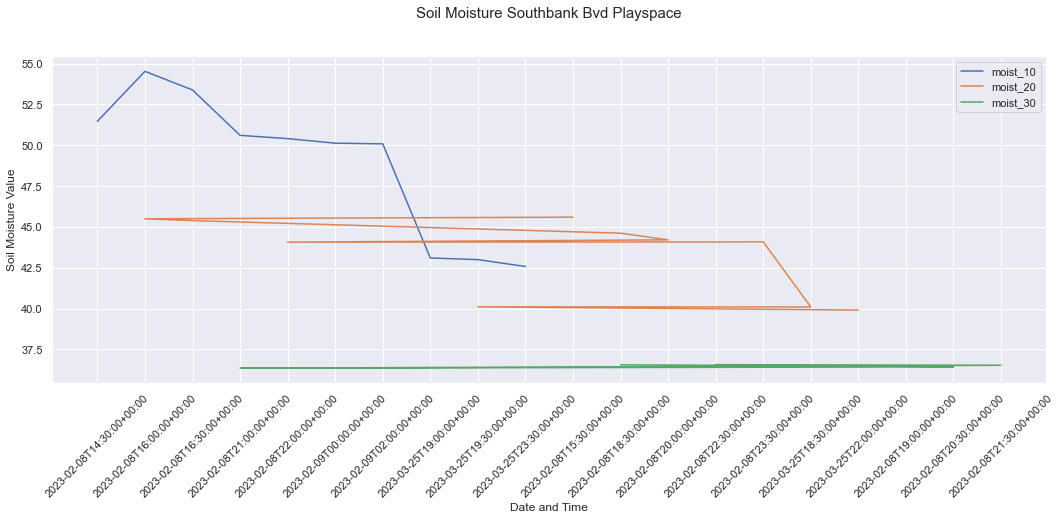

In [35]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(moist_10['local_time'], moist_10['soil_value'], label = 'moist_10')
ax.plot(moist_20['local_time'], moist_20['soil_value'], label = 'moist_20')
ax.plot(moist_30['local_time'], moist_30['soil_value'], label = 'moist_30')
#ax.plot(moist_40['local_time'], moist_40['soil_value'], label = 'moist_40')
#ax.plot(moist_50['local_time'], moist_50['soil_value'], label = 'moist_50')
#ax.plot(moist_60['local_time'], moist_60['soil_value'], label = 'moist_60')
#ax.plot(moist_70['local_time'], moist_70['soil_value'], label = 'moist_70')
#ax.plot(moist_80['local_time'], moist_80['soil_value'], label = 'moist_80')


ax.set_xlabel("Date and Time")
ax.set_ylabel("Soil Moisture Value")
ax.set_title("Soil Moisture Southbank Bvd Playspace", y=1.1, fontsize=15)

ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.legend()
plt.show()

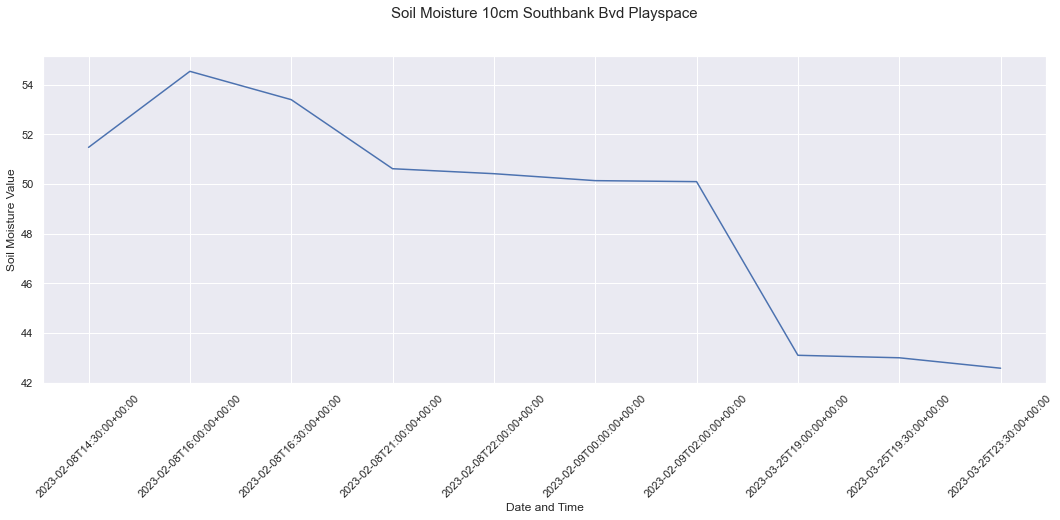

In [41]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(moist_10['local_time'], moist_10['soil_value'])

ax.set_xlabel("Date and Time")
ax.set_ylabel("Soil Moisture Value")
ax.set_title("Soil Moisture 10cm Southbank Bvd Playspace", y=1.1, fontsize=15)

ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

,timestamp,size,local_time,site_name,site_id,probe_id,probe_measure,soil_value,unit,json_featuretype
46,2023-09-01T07:08:46.91Z,136,2023-01-04T14:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.80,%VWC,SoilSensorData
57,2023-09-01T07:08:46.91Z,137,2023-01-04T15:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.83,%VWC,SoilSensorData
69,2023-09-01T07:08:46.91Z,137,2023-01-04T16:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,50.88,%VWC,SoilSensorData
74,2023-09-01T07:08:46.91Z,137,2023-01-04T18:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,50.25,%VWC,SoilSensorData
84,2023-09-01T07:08:46.91Z,136,2023-01-04T19:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,50.10,%VWC,SoilSensorData
36,2023-09-01T07:08:46.91Z,137,2023-01-04T22:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.85,%VWC,SoilSensorData
78,2023-09-01T07:08:46.91Z,137,2023-01-04T22:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.76,%VWC,SoilSensorData
42,2023-09-01T07:08:46.91Z,136,2023-01-04T23:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.60,%VWC,SoilSensorData
99,2023-09-01T07:08:46.91Z,137,2023-01-05T00:00:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.73,%VWC,SoilSensorData
73,2023-09-01T07:08:46.91Z,137,2023-01-05T00:30:00+00:00,Southbank Bvd Playspace,126588,2239493,Soil Moisture 020cm,49.59,%VWC,SoilSensorData


In [43]:
dataset = 'soil-sensor-locations'
soil_loc = extract_dataframe(base_url, dataset)

In [64]:
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

#Dataset name
dataset = 'soil-sensor-locations'
number_of_records = 84

# Add a filter for the number of results returned
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

soil_loc_url = f'{base_url}{dataset}/{filters}'
soil_loc_url

result = requests.get(soil_loc_url)
result_json = result.json()
records = result_json['results']
soil_loc = pd.json_normalize(records)

In [65]:
soil_loc

,site_id,site_name,property_name,latitude,longitude,location.lon,location.lat
0,50921,Replaced by op63369,Fitzroy Gardens,-37.81082691661315,144.98178719594011,144.981787,-37.810827
1,50924,Fitzroy West 09,Fitzroy Gardens,-37.81067469320403,144.979618148459,144.979618,-37.810675
2,64971,5th Fairway,Royal Park,-37.77920999998876,144.95251000000945,144.952510,-37.779210
3,64973,Argyle Square,Argyle Square,-37.8029015228744,144.966010728849,144.966011,-37.802902
4,64976,9th Fairway,Royal Park,-37.78291999998904,144.95566000000628,144.955660,-37.782920
...,...,...,...,...,...,...,...
79,75506,Powlett Reserve,Powlett Reserve,-37.81139911988671,144.98711120274965,144.987111,-37.811399
80,75507,Bandstand,Fitzroy Gardens,-37.811929606805606,144.98107870431852,144.981079,-37.811930
81,101035,Princess bridge West p06,None,-37.81934619998584,144.96822599998345,144.968226,-37.819346
82,101036,Princess bridge SE P01,None,-37.819894199985846,144.968679499984,144.968679,-37.819894


In [85]:
soil_loc['latitude'] = soil_loc['latitude'].astype(float)
soil_loc['longitude'] = soil_loc['longitude'].astype(float)

In [86]:
# Create a base map
m = folium.Map(location=[soil_loc['latitude'].mean(), soil_loc['longitude'].mean()], zoom_start=15)

# Add markers for each sensor site
for _, row in soil_loc.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Site ID: {row['site_id']}<br>Site Name: {row['site_name']}<br>Property Name: {row['property_name']}",
        icon=folium.Icon(icon="cloud"),
    ).add_to(m)

# Display the map
m.save('sensor_locations.html')

In [87]:
m